### Домашнее задание к занятию «Сингулярный спектральный анализ»


Провести анализ с помощью SSA любом из временных рядов с первого занятия. При желании, можно воспользоваться своим временным рядом (работа, kaggle и тд). Посмотрите на результаты с разными длинами окон. Обязательно визуализируйте результаты, аналогично материалу с занятия.

In [1]:
# Load the usual suspects:
import numpy as np
from numpy import pi
import matplotlib.pyplot as plt
import pandas as pd

# Fiddle with figure settings here:
plt.rcParams['figure.figsize'] = (15,8)
plt.rcParams['font.size'] = 14
plt.rcParams['image.cmap'] = 'plasma'
plt.rcParams['axes.linewidth'] = 2
# Set the default colour cycle (in case someone changes it...)
from cycler import cycler
cols = plt.get_cmap('tab10').colors
plt.rcParams['axes.prop_cycle'] = cycler(color=cols)

# A simple little 2D matrix plotter, excluding x and y labels.
def plot_2d(m, title=""):
    plt.imshow(m)
    plt.xticks([])
    plt.yticks([])
    plt.title(title)

In [2]:
class SSA(object):
    
    __supported_types = (pd.Series, np.ndarray, list)
    
    def __init__(self, tseries, L, save_mem=True):
        """
        Decomposes the given time series with a singular-spectrum analysis. Assumes the values of the time series are
        recorded at equal intervals.
        
        Parameters
        ----------
        tseries : The original time series, in the form of a Pandas Series, NumPy array or list. 
        L : The window length. Must be an integer 2 <= L <= N/2, where N is the length of the time series.
        save_mem : Conserve memory by not retaining the elementary matrices. Recommended for long time series with
            thousands of values. Defaults to True.
        
        Note: Even if an NumPy array or list is used for the initial time series, all time series returned will be
        in the form of a Pandas Series or DataFrame object.
        """
        
        # Tedious type-checking for the initial time series
        if not isinstance(tseries, self.__supported_types):
            raise TypeError("Unsupported time series object. Try Pandas Series, NumPy array or list.")
        
        # Checks to save us from ourselves
        self.N = len(tseries)
        if not 2 <= L <= self.N/2:
            raise ValueError("The window length must be in the interval [2, N/2].")
        
        self.L = L
        self.orig_TS = pd.Series(tseries)
        self.K = self.N - self.L + 1
        
        # Embed the time series in a trajectory matrix
        self.X = np.array([self.orig_TS.values[i:L+i] for i in range(0, self.K)]).T
        
        # Decompose the trajectory matrix
        self.U, self.Sigma, VT = np.linalg.svd(self.X)
        self.d = np.linalg.matrix_rank(self.X)
        
        self.TS_comps = np.zeros((self.N, self.d))
        
        if not save_mem:
            # Construct and save all the elementary matrices
            self.X_elem = np.array([ self.Sigma[i]*np.outer(self.U[:,i], VT[i,:]) for i in range(self.d) ])

            # Diagonally average the elementary matrices, store them as columns in array.           
            for i in range(self.d):
                X_rev = self.X_elem[i, ::-1]
                self.TS_comps[:,i] = [X_rev.diagonal(j).mean() for j in range(-X_rev.shape[0]+1, X_rev.shape[1])]
            
            self.V = VT.T
        else:
            # Reconstruct the elementary matrices without storing them
            for i in range(self.d):
                X_elem = self.Sigma[i]*np.outer(self.U[:,i], VT[i,:])
                X_rev = X_elem[::-1]
                self.TS_comps[:,i] = [X_rev.diagonal(j).mean() for j in range(-X_rev.shape[0]+1, X_rev.shape[1])]
            
            self.X_elem = "Re-run with save_mem=False to retain the elementary matrices."
            
            # The V array may also be very large under these circumstances, so we won't keep it.
            self.V = "Re-run with save_mem=False to retain the V matrix."
        
        # Calculate the w-correlation matrix.
        self.calc_wcorr()
            
    def components_to_df(self, n=0):
        """
        Returns all the time series components in a single Pandas DataFrame object.
        """
        if n > 0:
            n = min(n, self.d)
        else:
            n = self.d
        
        # Create list of columns - call them F0, F1, F2, ...
        cols = ["F{}".format(i) for i in range(n)]
        return pd.DataFrame(self.TS_comps[:, :n], columns=cols, index=self.orig_TS.index)
            
    
    def reconstruct(self, indices):
        """
        Reconstructs the time series from its elementary components, using the given indices. Returns a Pandas Series
        object with the reconstructed time series.
        
        Parameters
        ----------
        indices: An integer, list of integers or slice(n,m) object, representing the elementary components to sum.
        """
        if isinstance(indices, int): indices = [indices]
        
        ts_vals = self.TS_comps[:,indices].sum(axis=1)
        return pd.Series(ts_vals, index=self.orig_TS.index)
    
    def calc_wcorr(self):
        """
        Calculates the w-correlation matrix for the time series.
        """
             
        # Calculate the weights
        w = np.array(list(np.arange(self.L)+1) + [self.L]*(self.K-self.L-1) + list(np.arange(self.L)+1)[::-1])
        
        def w_inner(F_i, F_j):
            return w.dot(F_i*F_j)
        
        # Calculated weighted norms, ||F_i||_w, then invert.
        F_wnorms = np.array([w_inner(self.TS_comps[:,i], self.TS_comps[:,i]) for i in range(self.d)])
        F_wnorms = F_wnorms**-0.5
        
        # Calculate Wcorr.
        self.Wcorr = np.identity(self.d)
        for i in range(self.d):
            for j in range(i+1,self.d):
                self.Wcorr[i,j] = abs(w_inner(self.TS_comps[:,i], self.TS_comps[:,j]) * F_wnorms[i] * F_wnorms[j])
                self.Wcorr[j,i] = self.Wcorr[i,j]
    
    def plot_wcorr(self, min=None, max=None):
        """
        Plots the w-correlation matrix for the decomposed time series.
        """
        if min is None:
            min = 0
        if max is None:
            max = self.d
        
        if self.Wcorr is None:
            self.calc_wcorr()
        
        ax = plt.imshow(self.Wcorr)
        plt.xlabel(r"$\tilde{F}_i$")
        plt.ylabel(r"$\tilde{F}_j$")
        plt.colorbar(ax.colorbar, fraction=0.045)
        ax.colorbar.set_label("$W_{i,j}$")
        plt.clim(0,1)
        
        # For plotting purposes:
        if max == self.d:
            max_rnge = self.d-1
        else:
            max_rnge = max
        
        plt.xlim(min-0.5, max_rnge+0.5)
        plt.ylim(max_rnge+0.5, min-0.5)

In [3]:
series = pd.read_csv("Series/weekly-closings-of-the-dowjones-.csv")['Close']
series

0      890.19
1      901.80
2      888.51
3      887.78
4      858.43
        ...  
157    791.77
158    787.23
159    787.94
160    784.57
161    752.58
Name: Close, Length: 162, dtype: float64

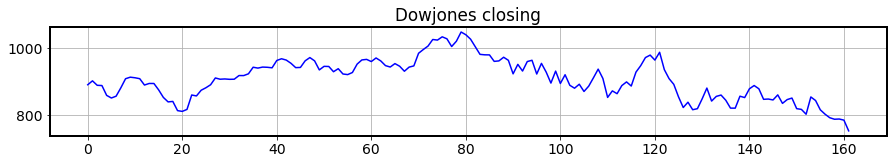

In [4]:
plt.style.context('bmh')
plt.figure(figsize=(15, 2))   
series.plot(color='blue')
plt.title('Dowjones closing')
plt.grid()

Text(0.5, 1.0, '$L=2$ for the Dowjones closing')

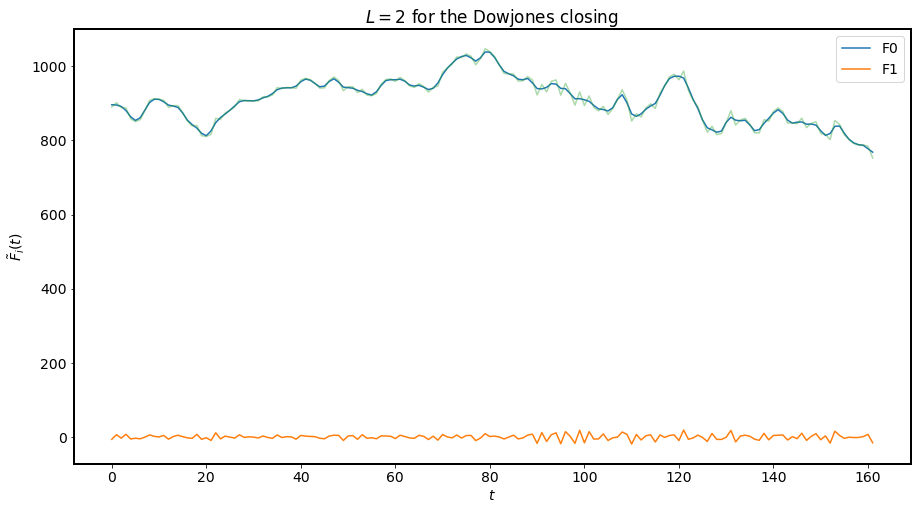

In [5]:
F_ssa_L2 = SSA(series, 2)
F_ssa_L2.components_to_df().plot()
F_ssa_L2.orig_TS.plot(alpha=0.4)
plt.xlabel("$t$")
plt.ylabel(r"$\tilde{F}_i(t)$")
plt.title(r"$L=2$ for the Dowjones closing")

Text(0.5, 1.0, '$L=5$ for the Dowjones closing')

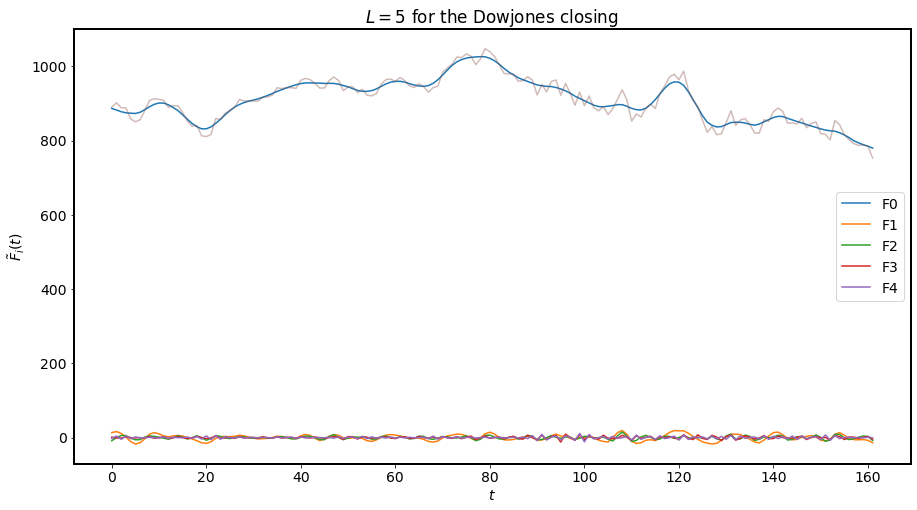

In [6]:
F_ssa_L5 = SSA(series, 5)
F_ssa_L5.components_to_df().plot()
F_ssa_L5.orig_TS.plot(alpha=0.4)
plt.xlabel("$t$")
plt.ylabel(r"$\tilde{F}_i(t)$")
plt.title(r"$L=5$ for the Dowjones closing")

Text(0.5, 1.0, '$L=20$ for the Dowjones closing')

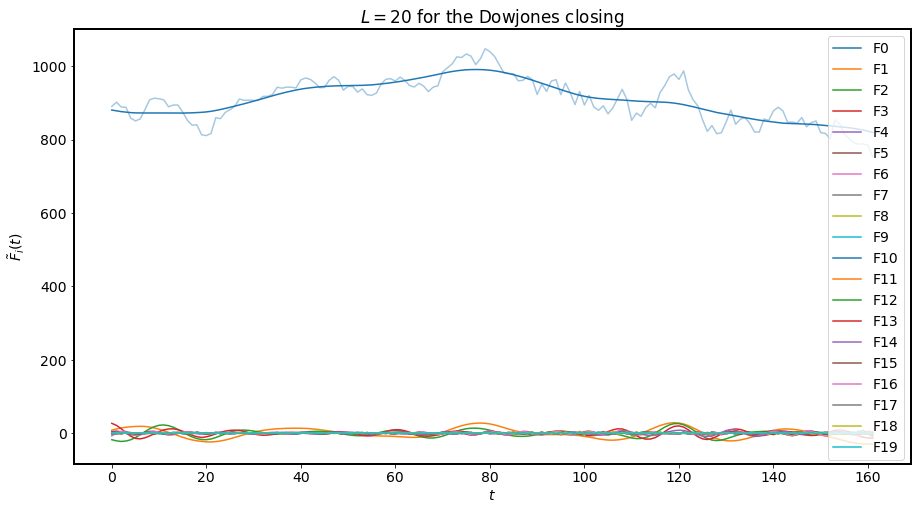

In [7]:
F_ssa_L20 = SSA(series, 20)
F_ssa_L20.components_to_df().plot()
F_ssa_L20.orig_TS.plot(alpha=0.4)
plt.xlabel("$t$")
plt.ylabel(r"$\tilde{F}_i(t)$")
plt.title(r"$L=20$ for the Dowjones closing")

Text(0.5, 1.0, '$L=40$ for the Dowjones closing')

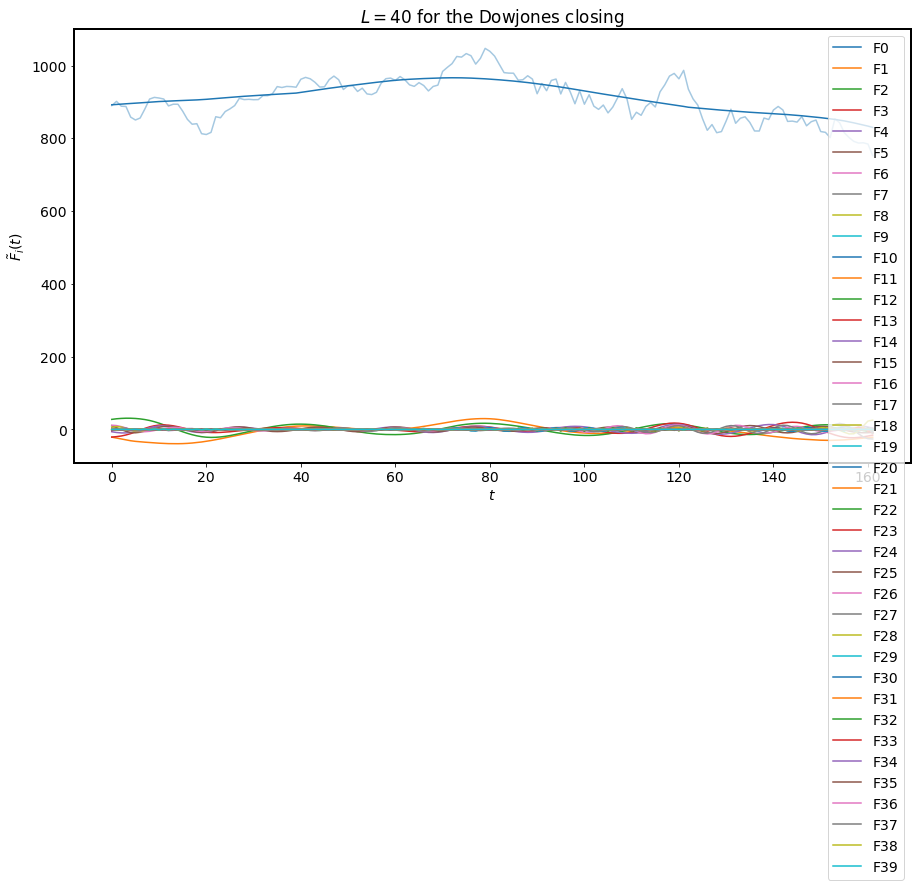

In [8]:
F_ssa_L40 = SSA(series, 40)
F_ssa_L40.components_to_df().plot()
F_ssa_L40.orig_TS.plot(alpha=0.4)
plt.xlabel("$t$")
plt.ylabel(r"$\tilde{F}_i(t)$")
plt.title(r"$L=40$ for the Dowjones closing")

Text(0.5, 1.0, '$L=80$ for the Dowjones closing')

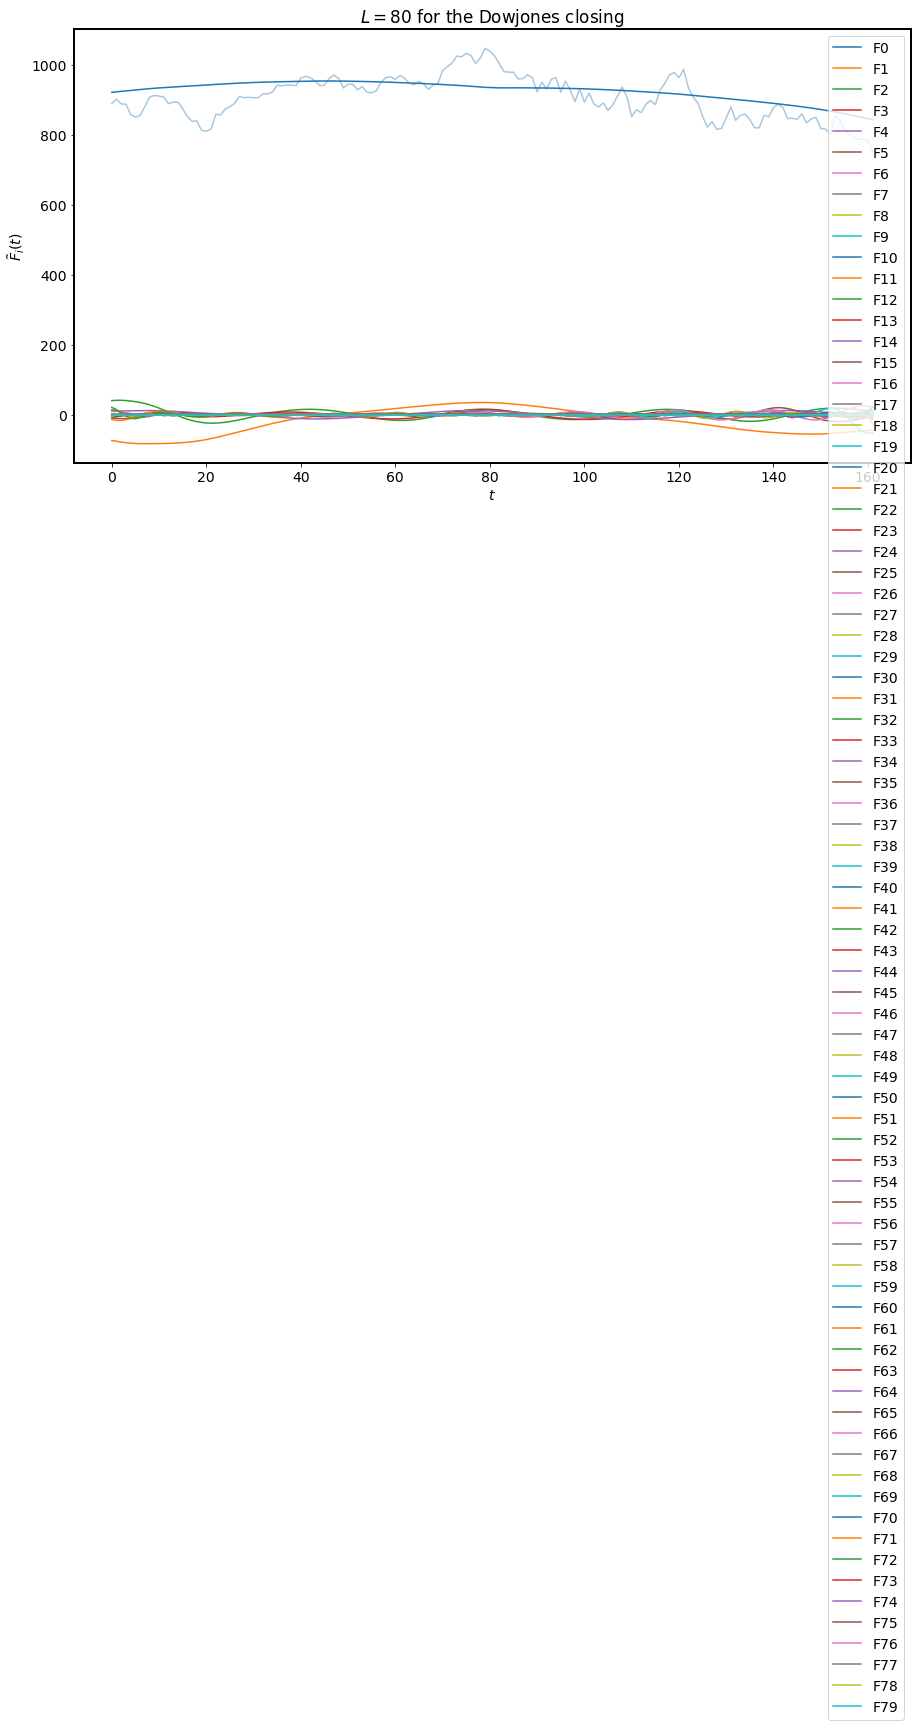

In [9]:
F_ssa_L80 = SSA(series, 80)
F_ssa_L80.components_to_df().plot()
F_ssa_L80.orig_TS.plot(alpha=0.4)
plt.xlabel("$t$")
plt.ylabel(r"$\tilde{F}_i(t)$")
plt.title(r"$L=80$ for the Dowjones closing")

#### Рассмотрим полученную w-корреляционную матрицу и примем некоторые решения о группировке.

#### Длина окна L = 80

Text(0.5, 1.0, 'W-Correlation for the Dowjones closing, $L=80$')

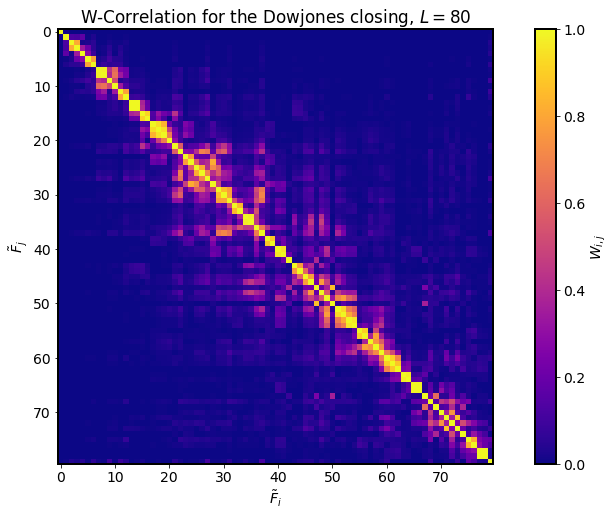

In [10]:
F_ssa_L80 = SSA(series, 80)
F_ssa_L80.plot_wcorr()
plt.title("W-Correlation for the Dowjones closing, $L=80$")

##### Корреляционная матрица примерно разбита на два блока:
- *F0-F19;
- *F20-F80

##### Увеличим блок F0-F20 и сгруппируем признаки

Text(0.5, 1.0, 'W-Correlation for the Dowjones closing, $L=20$')

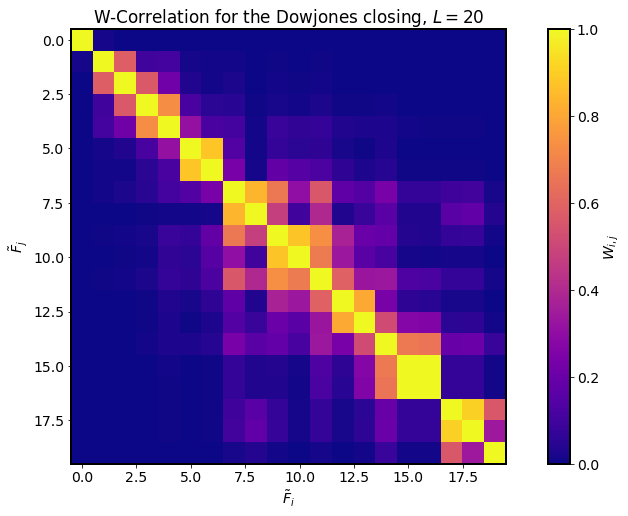

In [18]:
F_ssa_L20 = SSA(series, 20)
F_ssa_L20.plot_wcorr()
plt.title("W-Correlation for the Dowjones closing, $L=20$")

Объединяем в 5 групп:
- F0 = [0]
- F1 = [1, 2, 3]
- F2 = [4, 5, 6]
- F3 = [7, 8, 9, 10, 11, 12, 13, 14, 15, 16]
- F4 = [17, 18, 19]

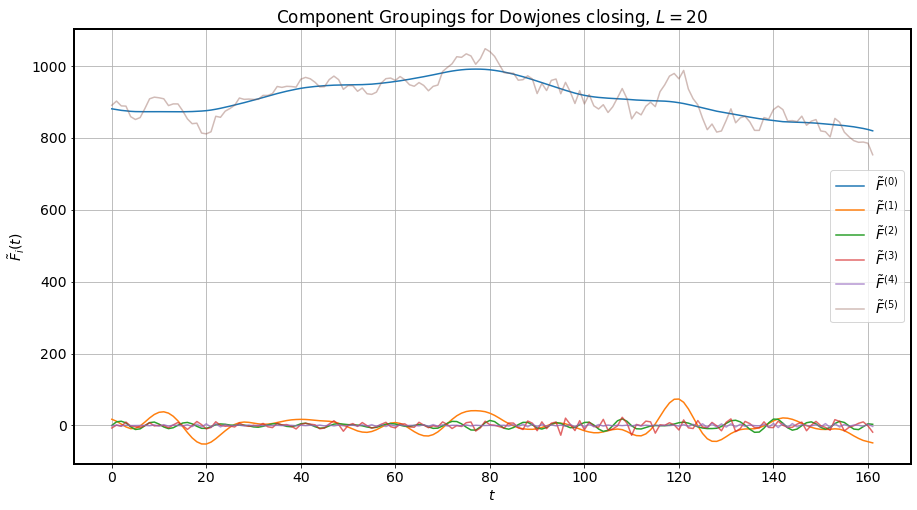

In [19]:
F_ssa_L20.reconstruct(0).plot()
F_ssa_L20.reconstruct([1,2,3]).plot()
F_ssa_L20.reconstruct([4,5,6]).plot()
F_ssa_L20.reconstruct(slice(7,17)).plot(alpha=0.7)
F_ssa_L20.reconstruct(slice(17,20)).plot(alpha=0.7)
F_ssa_L20.orig_TS.plot(alpha=0.4)
plt.title("Component Groupings for Dowjones closing, $L=20$")
plt.xlabel("$t$")
plt.ylabel(r"$\tilde{F}_i(t)$")
plt.legend([r"$\tilde{{F}}^{{({0})}}$".format(i) for i in range(6)] + ["Original TS"]);
plt.grid()

##### Можно выделить тренд

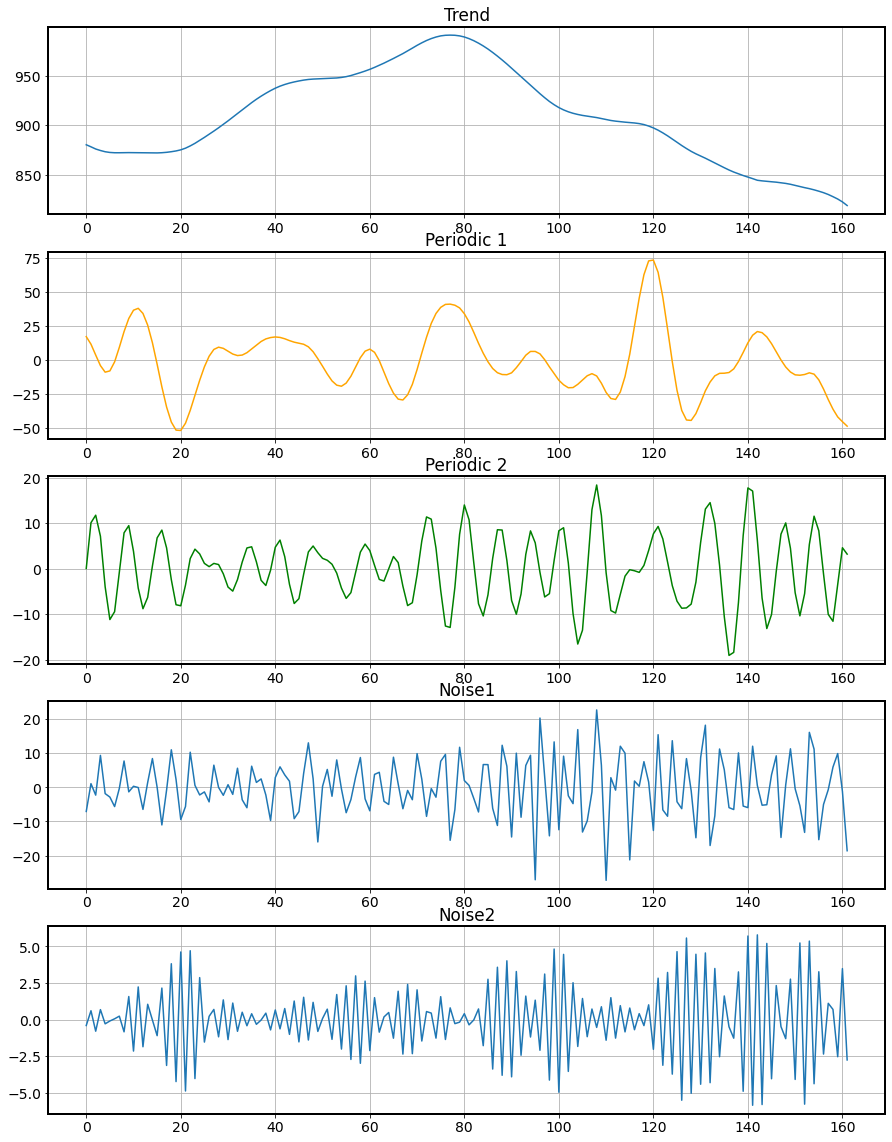

<Figure size 1080x144 with 0 Axes>

In [20]:
fig, ax = plt.subplots(5, figsize=(15, 20))
plt.figure(figsize=(15, 2))
ax[0].plot(F_ssa_L20.reconstruct(0))
ax[0].set_title('Trend')
ax[0].grid()
ax[1].plot(F_ssa_L20.reconstruct([1,2,3]), c='orange')
ax[1].set_title('Periodic 1')
ax[1].grid()
ax[2].plot(F_ssa_L20.reconstruct([4,5,6]), c='g')
ax[2].set_title('Periodic 2')
ax[2].grid()
ax[3].plot(F_ssa_L20.reconstruct(slice(7,17)))
ax[3].set_title('Noise1')
ax[3].grid()
ax[4].plot(F_ssa_L20.reconstruct(slice(17,20)))
ax[4].set_title('Noise2')
ax[4].grid()

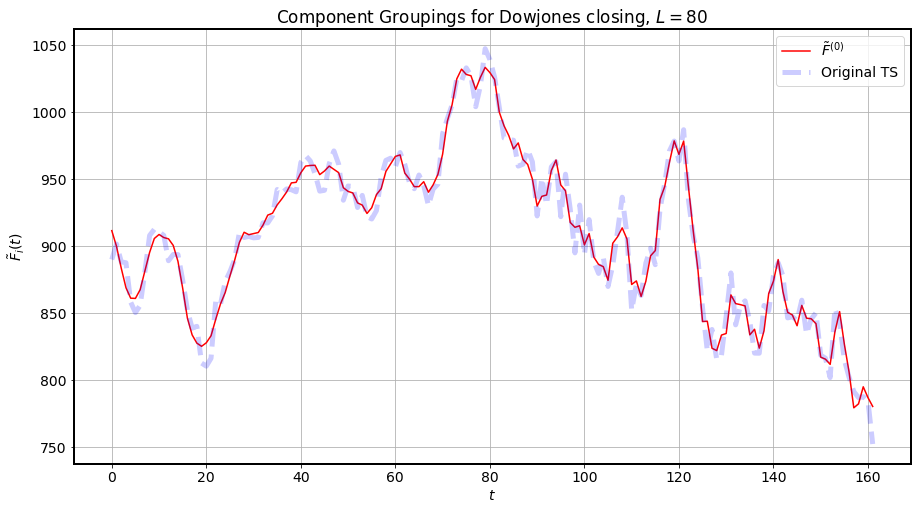

In [21]:
F_ssa_L80.reconstruct(slice(0, 20)).plot(c= 'red')
F_ssa_L80.orig_TS.plot(c = 'b', alpha=0.2, linestyle='--', linewidth=5)
plt.title("Component Groupings for Dowjones closing, $L=80$")
plt.xlabel("$t$")
plt.ylabel(r"$\tilde{F}_i(t)$")
plt.legend([r"$\tilde{{F}}^{{({0})}}$".format(i) for i in range(1)] + ["Original TS"])
plt.grid()

Временной ряд "Dowjones closing" можно полностью описать с помощью суммы первых 19 компонент.